
## 1. Setup

First, we clone the UniverSeg repo and install necessary dependencies

In [1]:
!git clone https://github.com/JJGO/UniverSeg
!python -m pip install -r ./UniverSeg/requirements.txt

Cloning into 'UniverSeg'...
remote: Enumerating objects: 230, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 230 (delta 4), reused 8 (delta 3), pack-reused 216
Receiving objects: 100% (230/230), 35.26 MiB | 22.68 MiB/s, done.
Resolving deltas: 100% (100/100), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 515.9 kB/s eta 0:00:00


In [2]:
import math
import itertools

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import einops as E

Prepare `universeg`: import, setup GPU, and load model

In [3]:
import sys
sys.path.append('UniverSeg')

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from universeg import universeg
model = universeg(pretrained=True)
_ = model.to(device)

Downloading: "https://github.com/JJGO/UniverSeg/releases/download/weights/universeg_v1_nf64_ss64_STA.pt" to /root/.cache/torch/hub/checkpoints/universeg_v1_nf64_ss64_STA.pt
100%|██████████| 4.53M/4.53M [00:00<00:00, 55.0MB/s]


Prepare a quick helpful function for visualizing data for this tutorial

In [4]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))

    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)

    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    if title:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()

---


In [5]:
# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

In [6]:
# run inference and compute losses for one test image
@torch.no_grad()
def inference(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    score = dice_score(hard_pred, label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score}

---

#  Testing inference on KVASIR-SEG

Dataset and details here: https://paperswithcode.com/dataset/kvasir-seg

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
import os
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
from collections import defaultdict

imagenames = os.listdir('/content/gdrive/MyDrive/Kvasir-SEG/images')

kvasir = []
for imgname in imagenames:
  with open(f'/content/gdrive/MyDrive/Kvasir-SEG/images/{imgname}', 'r') as images_file, open(f'/content/gdrive/MyDrive/Kvasir-SEG/masks/{imgname}', 'r')  as masks_file:
    kvasir.append((images_file, masks_file))

# split dataset
n_support = 50
idx = np.random.permutation(len(kvasir))
kvasir_randomized = [kvasir[i] for i in idx]

support_imagenames, support_labelnames = [data[0] for data in kvasir_randomized[:n_support]], [data2[1] for data2 in kvasir_randomized[:n_support]]
kvasir_randomized = kvasir_randomized[n_support:]
kvasir_valid, kvasir_test, kvasir_train = kvasir_randomized[:int(0.1*len(kvasir_randomized))], kvasir_randomized[int(0.1*len(kvasir_randomized)):int(0.2*len(kvasir_randomized))], kvasir_randomized[int(0.2*len(kvasir_randomized)):]
print(f"training set size: {len(kvasir_train)},", f"validation set size: {len(kvasir_valid)},", f"testing set size: {len(kvasir_test)}")
print(f"dataset size: {len(kvasir_randomized)}")

training set size: 760, validation set size: 95, testing set size: 95
dataset size: 950


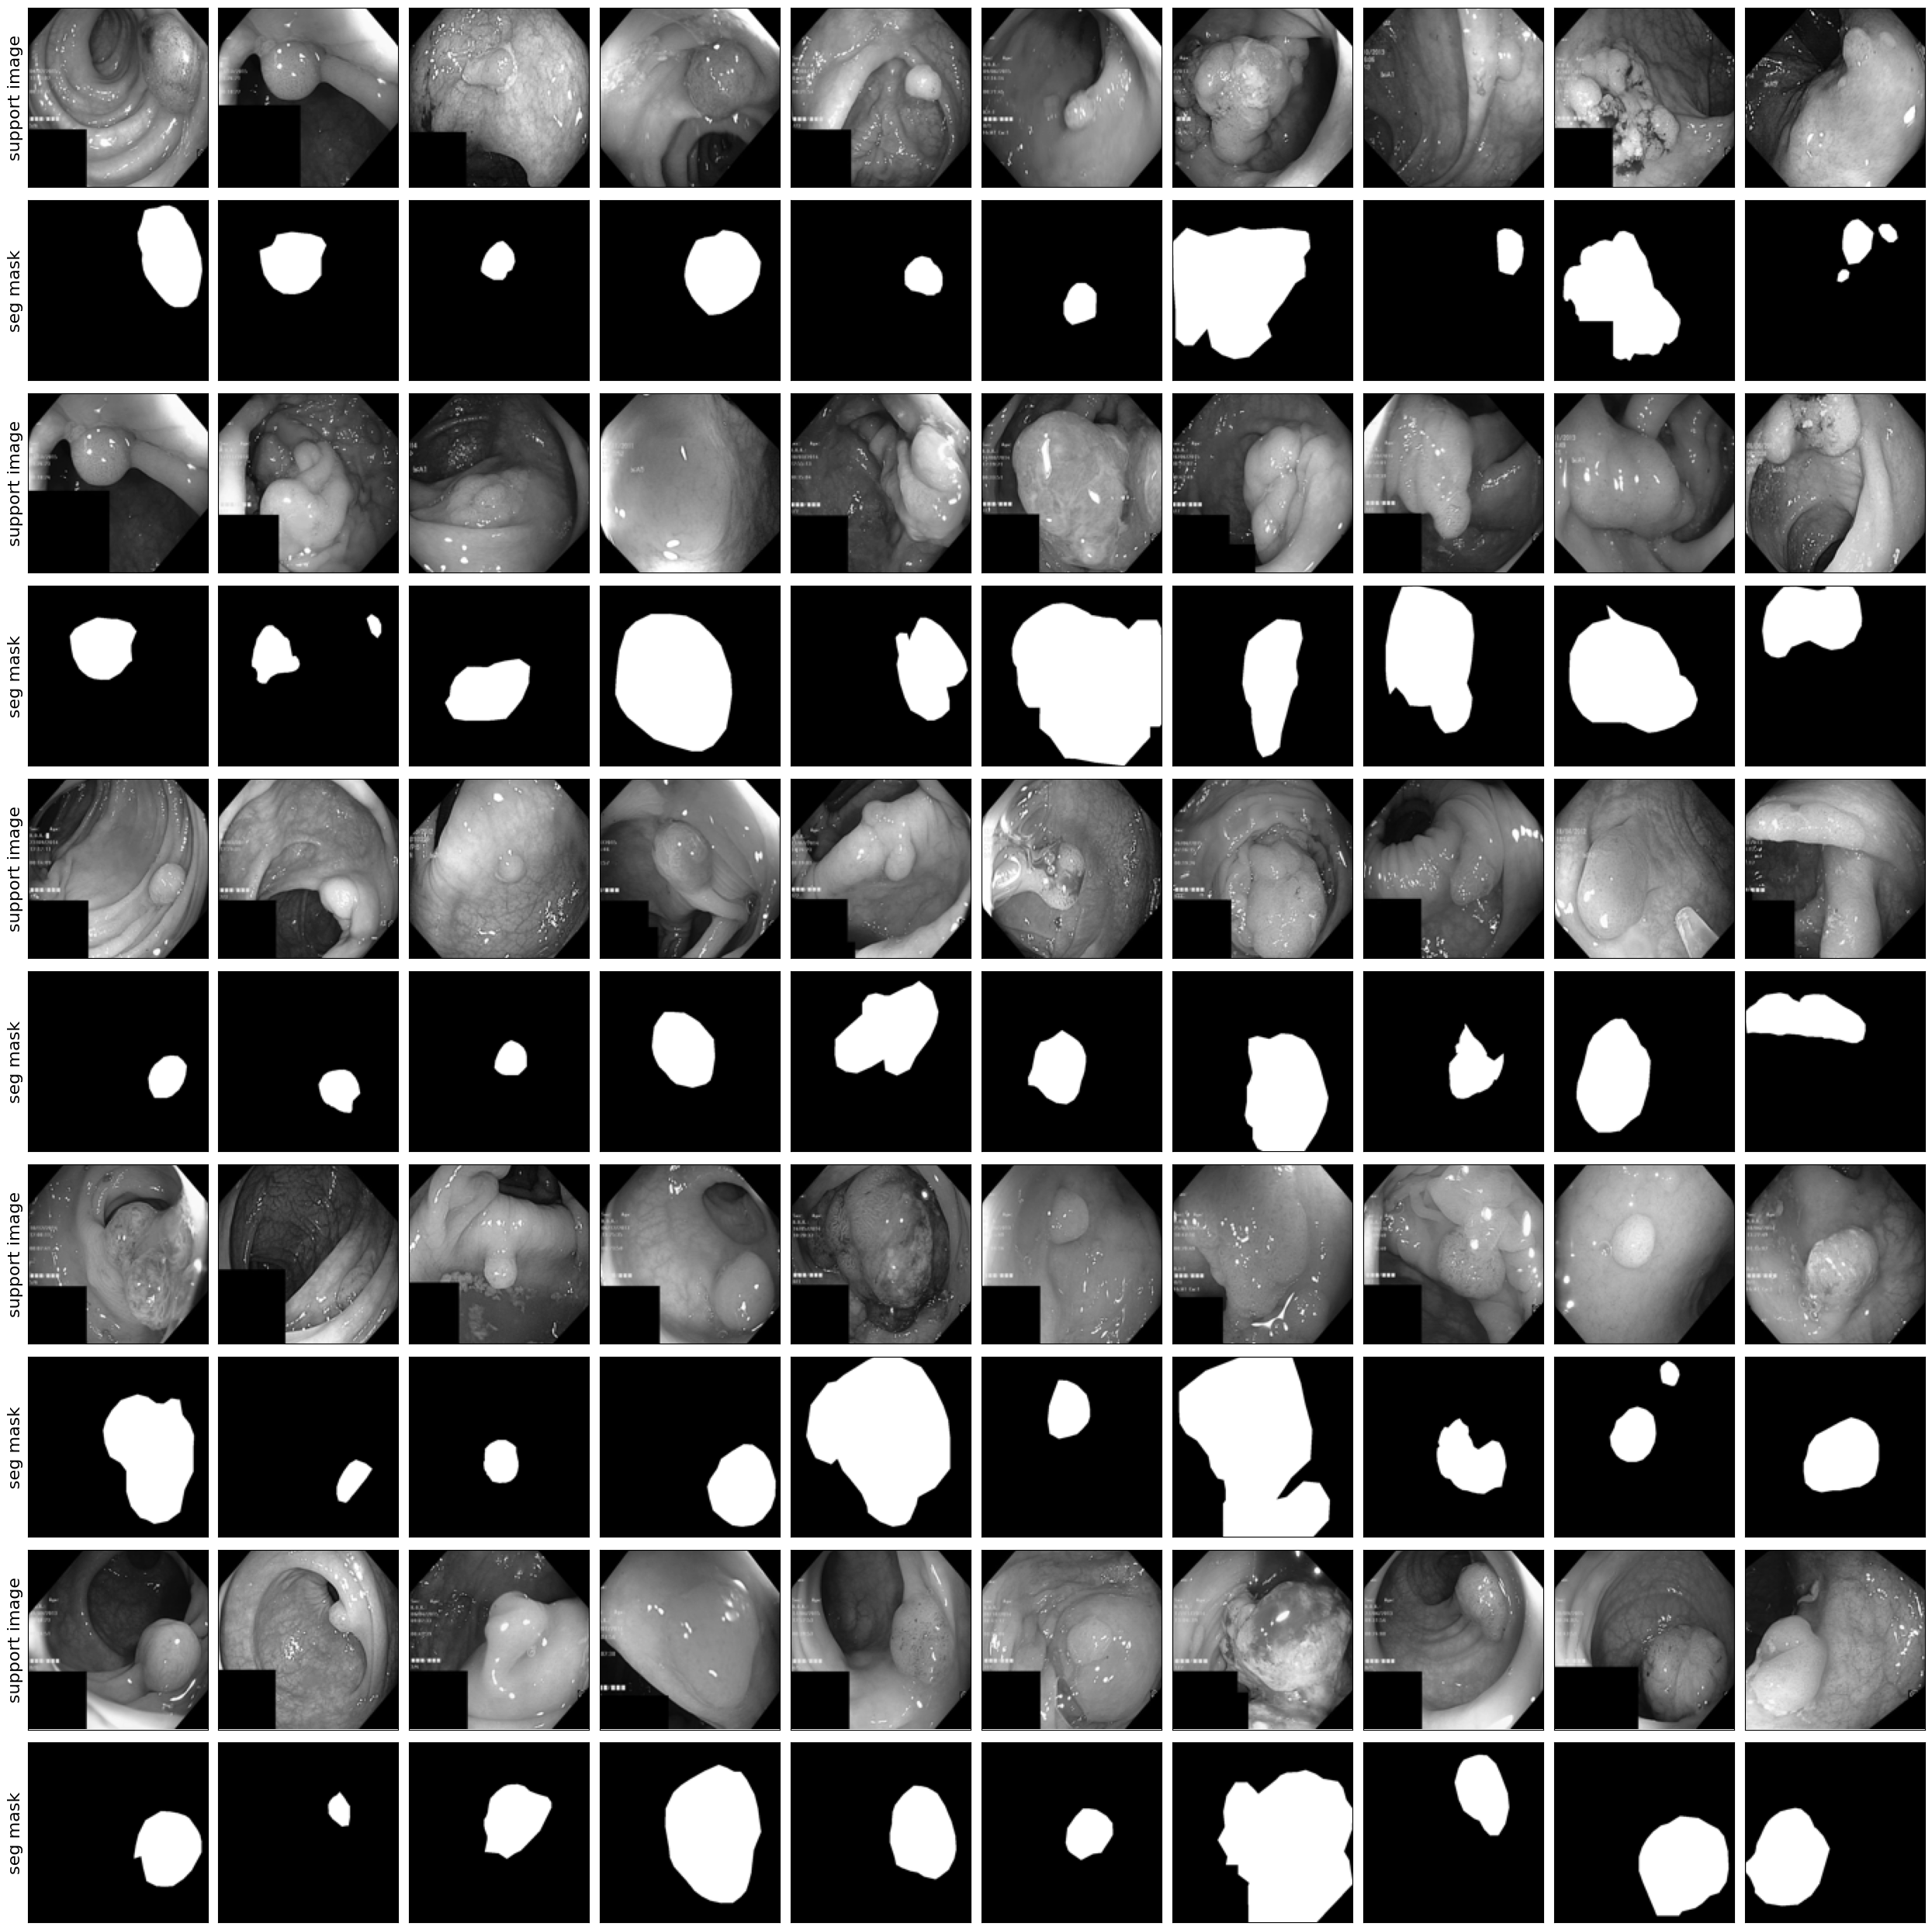

In [12]:
# initialize support images and labels
# select an image, label test pair
convert_tensor = transforms.ToTensor()
support_images = []
support_labels = []
for i in range(len(support_imagenames)):

  img = Image.open(support_imagenames[i].name)
  seg_mask = Image.open(support_labelnames[i].name)

  # resize
  img = img.resize((128,128))
  seg_mask = seg_mask.resize((128,128))

  # grayscale
  img = img.convert("L")
  seg_mask = seg_mask.convert("L")

  tensor_img = convert_tensor(img)
  tensor_lbl = convert_tensor(seg_mask)

  support_images.append(tensor_img)
  support_labels.append(tensor_lbl)

# visualize
visualize_tensors({
    'support image': support_images,
    'seg mask': support_labels
}, col_wrap=10)

support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

  0%|          | 0/4 [00:00<?, ?it/s]

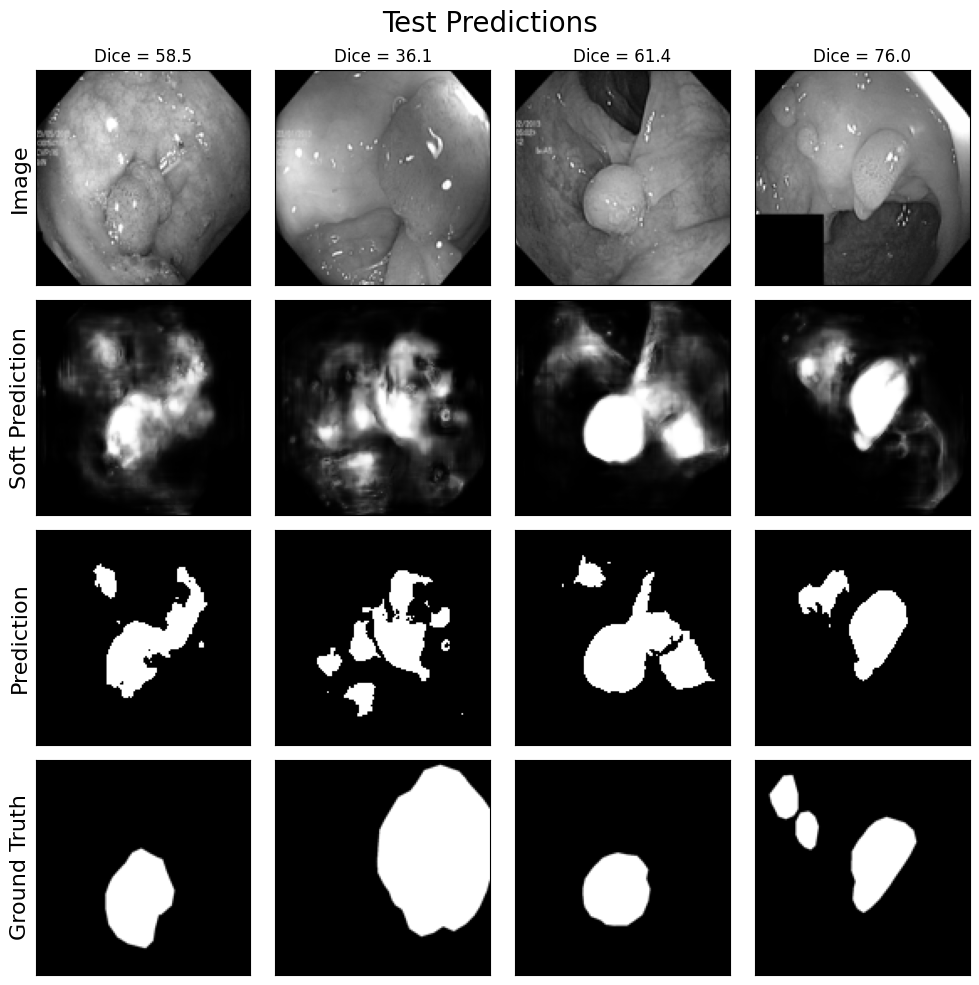

In [13]:
# select an image, label test pair
convert_tensor = transforms.ToTensor()
n_predictions = 4
idx = np.random.permutation(len(kvasir_test))[:n_predictions]
input_images = []
input_labels = []
for i in range(len(idx)):

  img = Image.open(kvasir_test[idx[i]][0].name)
  seg_mask = Image.open(kvasir_test[idx[i]][1].name)

  # resize
  img = img.resize((128,128))
  seg_mask = seg_mask.resize((128,128))

  # grayscale
  img = img.convert("L")
  seg_mask = seg_mask.convert("L")

  tensor_img = convert_tensor(img)
  tensor_lbl = convert_tensor(seg_mask)

  input_images.append(tensor_img)
  input_labels.append(tensor_lbl)

results = defaultdict(list)

# compute inference and save predictions and metrics for n_predictions
idxs = np.random.permutation(len(input_images))[:n_predictions]

for i in tqdm(idxs):
    image, label = input_images[i], input_labels[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)

# visualize the results, along with their scores
scores = results.pop('score')
visualize_tensors(results,
                  col_names=[f'Dice = {100*s:.1f}' for s in scores],
                  title='Test Predictions',
                  col_wrap=n_predictions)


In [14]:
from statistics import mean
# overall dice score on dataset
# select an image, label test pair
convert_tensor = transforms.ToTensor()
n_predictions = 4

input_images = []
input_labels = []
for i in range(len(kvasir_test)):

  img = Image.open(kvasir_test[i][0].name)
  seg_mask = Image.open(kvasir_test[i][1].name)

  # resize
  img = img.resize((128,128))
  seg_mask = seg_mask.resize((128,128))

  # grayscale
  img = img.convert("L")
  seg_mask = seg_mask.convert("L")

  tensor_img = convert_tensor(img)
  tensor_lbl = convert_tensor(seg_mask)

  input_images.append(tensor_img)
  input_labels.append(tensor_lbl)

  results = defaultdict(list)

  image, label = input_images[i], input_labels[i]
  vals = inference(model, image, label, support_images, support_labels)
  for k, v in vals.items():
      results[k].append(v)

# visualize the results, along with their scores
scores = results.pop('score')
# visualize_tensors(results,
#                   col_names=[f'Dice = {100*s:.1f}' for s in scores],
#                   title='Test Predictions',
#                   col_wrap=n_predictions)
print(f"average test set dice score: {mean(scores)}")

average test set dice score: 0.3698979616165161
